In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loaders.Loaders import CSVLoader
from splitters.splitters import SingletaskStratifiedSplitter
from metrics.Metrics import Metric
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, precision_score)
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, Conv1D, Flatten, Reshape, LSTM, Bidirectional
from models.kerasModels import KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop

import tensorflow as tf
print(tf.version.VERSION)

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings('ignore')

2.7.0


# CHECK GPU

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2022-01-22 17:00:54.062117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:54.068821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:54.069180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Using GPU: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Num GPUs Available:  1
Using GPU: /device:GPU:0


2022-01-22 17:00:54.084462: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-22 17:00:54.085502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:54.086302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:54.086923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Load

In [4]:
rdk_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]

str_bits = list(str(x) for x in bits)

In [5]:
loader = CSVLoader(rdk_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)

In [6]:
dataset = loader.create_dataset()
dataset.get_shape()

Mols_shape:  39990
Features_shape:  (39990, 205)
Labels_shape:  (39990,)


# Data Split

In [7]:
splitter = SingletaskStratifiedSplitter()
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset, frac_train=0.7)

input_dim = train_dataset.X.shape[1]

(27993, 205)
X not defined!
Defined features extracted!
(11997, 205)


# Model

In [8]:
def metrics(label_test, predict):
    print('METRICS:')
    print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
    print(f"Recall score:\n{recall_score(label_test, predict, average='macro')}\n")
    print(f"Precison score:\n{precision_score(label_test, predict, average='macro', zero_division=0)}\n")
    print(f"F1-score:\n{f1_score(label_test, predict, average='macro')}\n")
    print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
    print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
    print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")

## DNN

In [9]:
dnn = Sequential()
dnn.add(Dense(126, input_dim=input_dim, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(64, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))
# Compile model
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

2022-01-22 17:00:56.044786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:56.045256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:56.045676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:56.046082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 17:00:56.046406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [10]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 126)               25956     
                                                                 
 dropout (Dropout)           (None, 126)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8128      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 35,141
Trainable params: 35,141
Non-traina

In [11]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_dnn = dnn.fit(train_dataset.X, train_dataset.y, validation_split=0.15, epochs=7, batch_size=32, verbose=1)

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/7
744/744 [==============================] - 3s 4ms/step - loss: 0.5941 - binary_accuracy: 0.6832 - val_loss: 0.6602 - val_binary_accuracy: 0.6452
Epoch 2/7
744/744 [==============================] - 3s 4ms/step - loss: 0.5329 - binary_accuracy: 0.7324 - val_loss: 0.8022 - val_binary_accuracy: 0.5837
Epoch 3/7
744/744 [==============================] - 3s 4ms/step - loss: 0.4903 - binary_accuracy: 0.7611 - val_loss: 0.6849 - val_binary_accuracy: 0.6390
Epoch 4/7
744/744 [==============================] - 2s 3ms/step - loss: 0.4563 - binary_accuracy: 0.7863 - val_loss: 0.8283 - val_binary_accuracy: 0.5506
Epoch 5/7
744/744 [==============================] - 2s 3ms/step - loss: 0.4280 - binary_accuracy: 0.8042 - val_loss: 0.7204 - val_binary_accuracy: 0.6454
Epoch 6/7
744/744 [==============================] - 2s 3ms/step - loss: 0.4020 - binary_accuracy: 0.8175 - val_loss: 0.8525 - val_binary_accuracy: 0.5632
Epoch 7/7
74

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


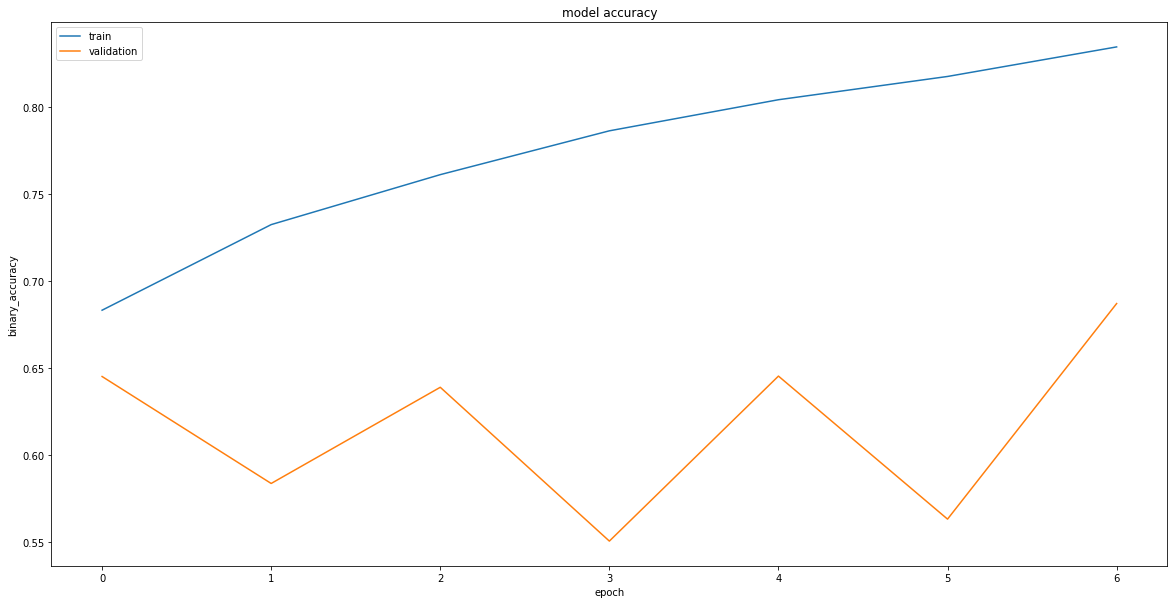

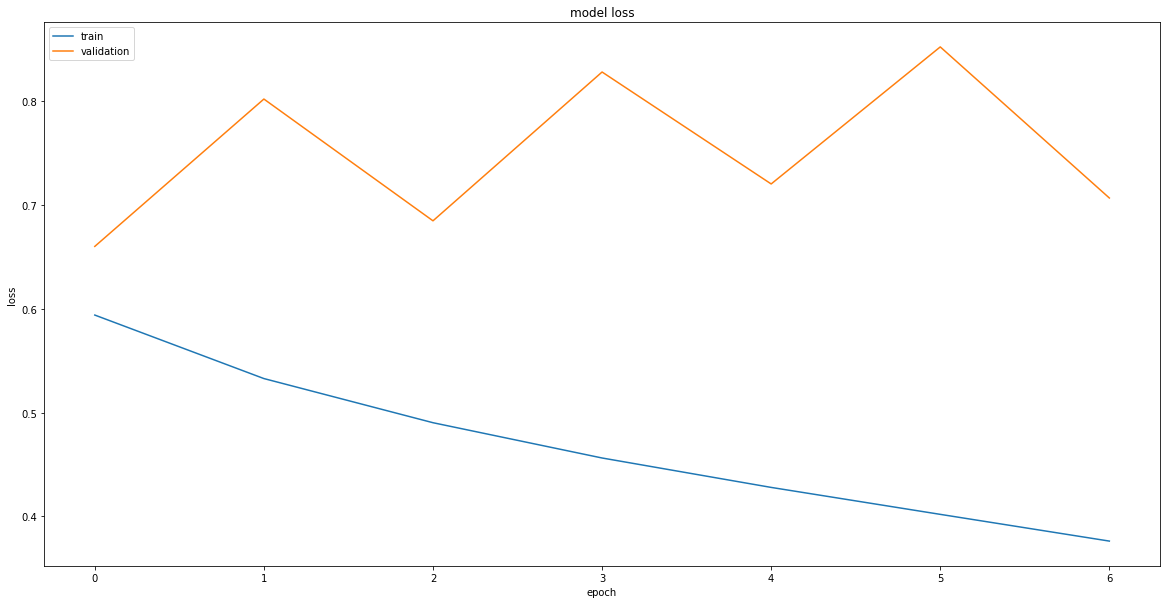

In [12]:
print(history_dnn.history.keys())
# summarize history for accuracy
plt.plot(history_dnn.history['binary_accuracy'])
plt.plot(history_dnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn.history['loss'])
plt.plot(history_dnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
pred_dnn = dnn.predict(test_dataset.X)

In [14]:
pred_dnn_bin= np.where(pred_dnn >= 0.50, 1,0)

In [15]:
metrics(test_dataset.y, pred_dnn_bin)

METRICS:
Accuracy score:
0.7702759023089105

Recall score:
0.7702730520664192

Precison score:
0.7715447435285003

F1-score:
0.7700059699877895

MCC score:
0.5418163032100116

Confusion matrix:
[[4826 1173]
 [1583 4415]]

Classification report:
              precision    recall  f1-score   support

           0      0.753     0.804     0.778      5999
           1      0.790     0.736     0.762      5998

    accuracy                          0.770     11997
   macro avg      0.772     0.770     0.770     11997
weighted avg      0.772     0.770     0.770     11997




## CNN

In [16]:
g_noise = 0.05
C1_K=8
C1_S=32
C2_K=16
C2_S=32

In [17]:
cnn = Sequential()
#Adding a bit of GaussianNoise also works as regularization
cnn.add(GaussianNoise(g_noise, input_shape=(input_dim,)))
#First two is number of filter + kernel size
cnn.add(Reshape((input_dim, 1)))
cnn.add(Conv1D(C1_K, (C1_S), activation='relu', padding="same"))
cnn.add(Conv1D(C2_K, (C2_S), padding="same", activation='relu'))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [18]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 205)              0         
 se)                                                             
                                                                 
 reshape (Reshape)           (None, 205, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 205, 8)            264       
                                                                 
 conv1d_1 (Conv1D)           (None, 205, 16)           4112      
                                                                 
 flatten (Flatten)           (None, 3280)              0         
                                                                 
 dropout_2 (Dropout)         (None, 3280)              0         
                                                      

In [19]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_cnn = cnn.fit(train_dataset.X, train_dataset.y, validation_split=0.15, epochs=7, batch_size=32, verbose=1)

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/7


2022-01-22 17:01:16.852429: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


744/744 [==============================] - 6s 5ms/step - loss: 0.5769 - binary_accuracy: 0.6977 - val_loss: 0.5407 - val_binary_accuracy: 0.7240
Epoch 2/7
744/744 [==============================] - 4s 5ms/step - loss: 0.5182 - binary_accuracy: 0.7459 - val_loss: 0.7967 - val_binary_accuracy: 0.4877
Epoch 3/7
744/744 [==============================] - 4s 5ms/step - loss: 0.4741 - binary_accuracy: 0.7714 - val_loss: 0.7815 - val_binary_accuracy: 0.5713
Epoch 4/7
744/744 [==============================] - 4s 5ms/step - loss: 0.4309 - binary_accuracy: 0.8007 - val_loss: 0.8028 - val_binary_accuracy: 0.5630
Epoch 5/7
744/744 [==============================] - 4s 5ms/step - loss: 0.3850 - binary_accuracy: 0.8273 - val_loss: 0.7772 - val_binary_accuracy: 0.5918
Epoch 6/7
744/744 [==============================] - 3s 5ms/step - loss: 0.3329 - binary_accuracy: 0.8553 - val_loss: 0.7119 - val_binary_accuracy: 0.6175
Epoch 7/7
744/744 [==============================] - 4s 5ms/step - loss: 0.2837 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


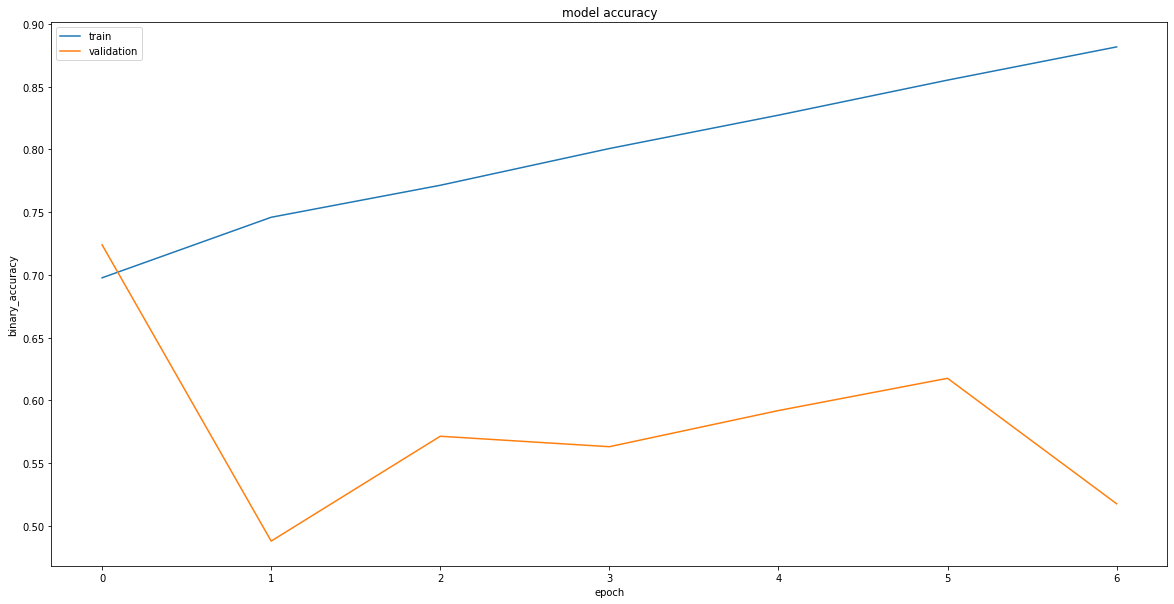

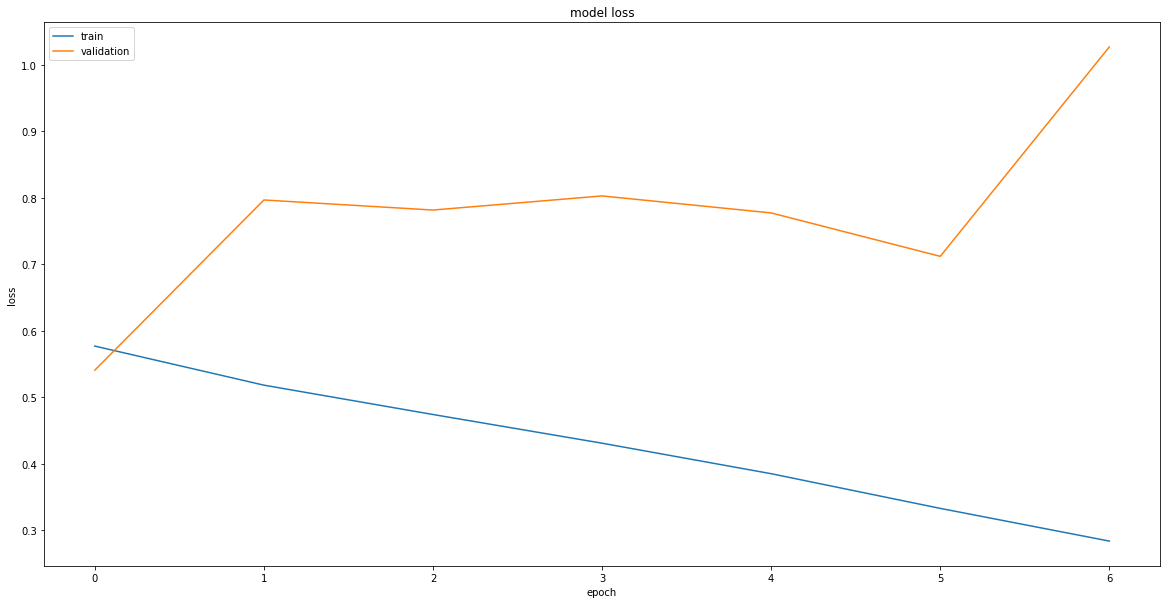

In [20]:
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['binary_accuracy'])
plt.plot(history_cnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
pred_cnn = cnn.predict(test_dataset.X)

In [22]:
pred_cnn_bin = np.where(pred_cnn >= 0.50, 1, 0)

In [23]:
metrics(test_dataset.y, pred_cnn_bin)

METRICS:
Accuracy score:
0.7485204634491956

Recall score:
0.7485088239392572

Precison score:
0.7695380654813417

F1-score:
0.743514760337112

MCC score:
0.5176198901109992

Confusion matrix:
[[5328  671]
 [2346 3652]]

Classification report:
              precision    recall  f1-score   support

           0      0.694     0.888     0.779      5999
           1      0.845     0.609     0.708      5998

    accuracy                          0.749     11997
   macro avg      0.770     0.749     0.744     11997
weighted avg      0.770     0.749     0.744     11997




## LSTM

In [24]:
x = np.reshape(train_dataset.X, (-1, 1, train_dataset.X.shape[1]))
y = np.reshape(train_dataset.y, (-1, 1, ))

In [25]:
xt = np.reshape(test_dataset.X, (-1, 1, test_dataset.X.shape[1]))
yt = np.reshape(test_dataset.y, (-1, 1, ))

In [26]:
x.shape

(27993, 1, 205)

In [27]:
y.shape

(27993, 1)

In [28]:
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(x.shape[1], x.shape[2]), activation='relu', return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, return_sequences = True))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
# Compile model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [29]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            171008    
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_6 (Dense)             (None, 1, 128)            8320      
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 228,865
Trainable params: 228,865
Non-tr

In [30]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_lstm = lstm.fit(x, y, validation_split=0.15, epochs=7, batch_size=32, verbose=1)

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/7
744/744 [==============================] - 9s 9ms/step - loss: 0.5884 - binary_accuracy: 0.6870 - val_loss: 0.7373 - val_binary_accuracy: 0.5873
Epoch 2/7
744/744 [==============================] - 6s 8ms/step - loss: 0.5407 - binary_accuracy: 0.7298 - val_loss: 0.9022 - val_binary_accuracy: 0.4723
Epoch 3/7
744/744 [==============================] - 6s 8ms/step - loss: 0.5024 - binary_accuracy: 0.7506 - val_loss: 0.9196 - val_binary_accuracy: 0.4503
Epoch 4/7
744/744 [==============================] - 6s 8ms/step - loss: 0.4670 - binary_accuracy: 0.7783 - val_loss: 0.6065 - val_binary_accuracy: 0.7126
Epoch 5/7
744/744 [==============================] - 6s 8ms/step - loss: 0.4348 - binary_accuracy: 0.7955 - val_loss: 0.6948 - val_binary_accuracy: 0.6480
Epoch 6/7
744/744 [==============================] - 6s 8ms/step - loss: 0.4067 - binary_accuracy: 0.8140 - val_loss: 0.5695 - val_binary_accuracy: 0.7137
Epoch 7/7
74

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


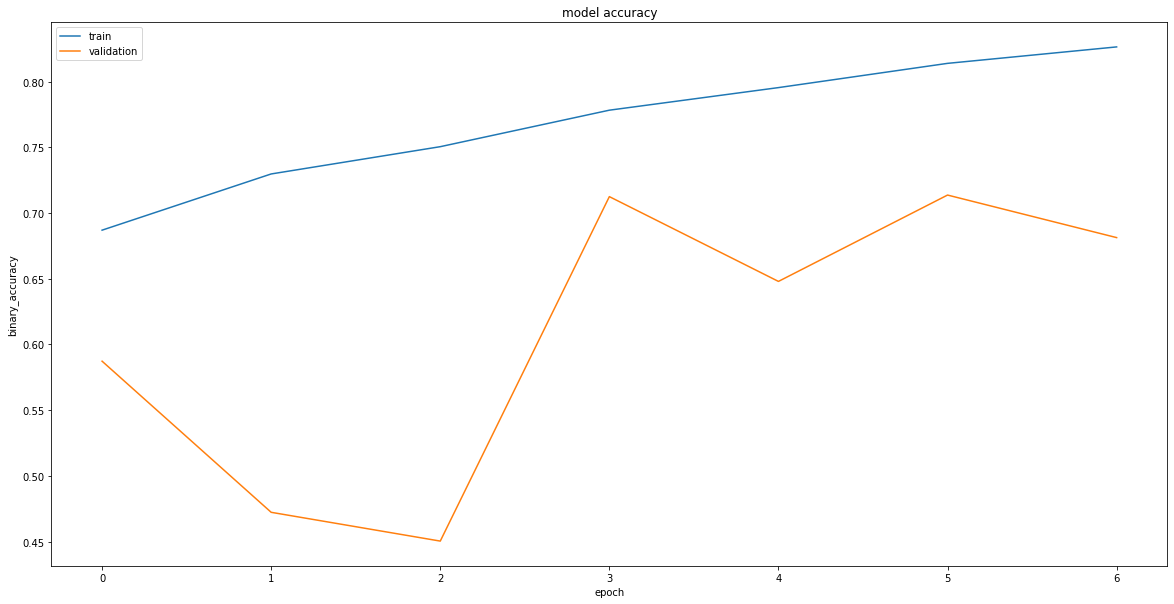

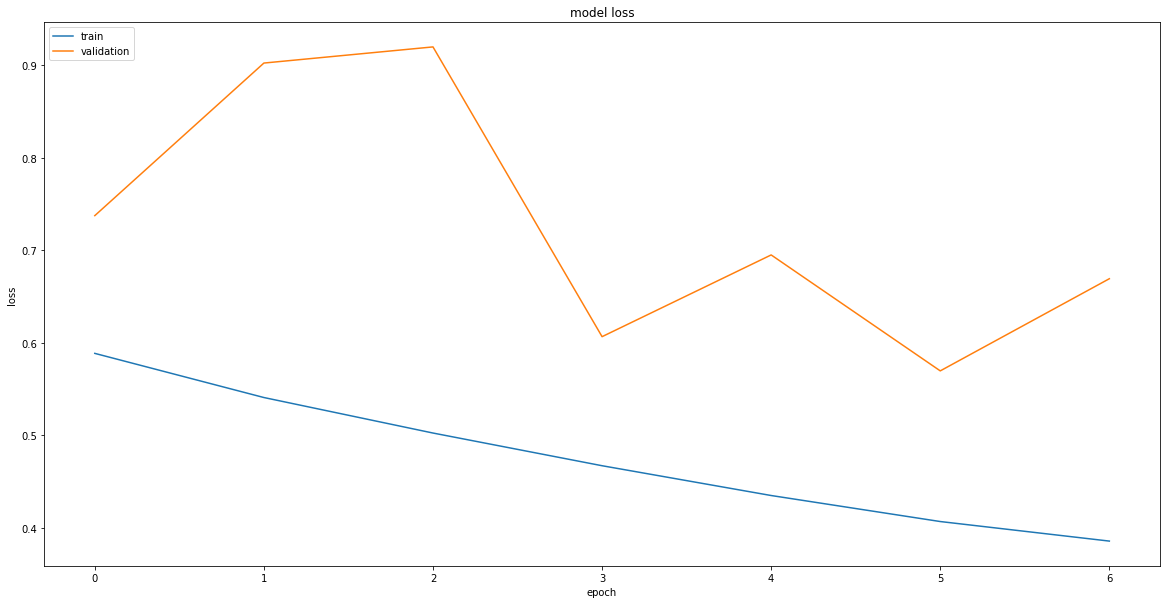

In [31]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['binary_accuracy'])
plt.plot(history_lstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
pred_lstm = lstm.predict(xt)

In [33]:
pred_lstm_bin = np.where(pred_lstm >= 0.50, 1, 0)

In [34]:
pred_lstm_bin.flatten()

array([0, 0, 1, ..., 1, 1, 1])

In [35]:
yt

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [36]:
metrics(yt, pred_lstm_bin.flatten())

METRICS:
Accuracy score:
0.7691089439026423

Recall score:
0.7691051765268648

Precison score:
0.7713244082778558

F1-score:
0.76863497259268

MCC score:
0.5404250282348496

Confusion matrix:
[[4885 1114]
 [1656 4342]]

Classification report:
              precision    recall  f1-score   support

           0      0.747     0.814     0.779      5999
           1      0.796     0.724     0.758      5998

    accuracy                          0.769     11997
   macro avg      0.771     0.769     0.769     11997
weighted avg      0.771     0.769     0.769     11997




# Bi-LSTM

In [37]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(256, return_sequences = True), input_shape=(x.shape[1], x.shape[2])))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(128, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(64, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Dense(1, activation='sigmoid'))
# Compile model
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [38]:
bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 512)           946176    
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                      

In [39]:
x.shape

(27993, 1, 205)

In [40]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_bilstm = bilstm.fit(x, y, validation_split=0.15, epochs=7, batch_size=32, verbose=1)

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/7
744/744 [==============================] - 18s 13ms/step - loss: 0.5799 - binary_accuracy: 0.6985 - val_loss: 0.8717 - val_binary_accuracy: 0.4980
Epoch 2/7
744/744 [==============================] - 8s 11ms/step - loss: 0.5307 - binary_accuracy: 0.7333 - val_loss: 0.5666 - val_binary_accuracy: 0.7152
Epoch 3/7
744/744 [==============================] - 8s 11ms/step - loss: 0.4812 - binary_accuracy: 0.7696 - val_loss: 0.8576 - val_binary_accuracy: 0.5149
Epoch 4/7
744/744 [==============================] - 8s 10ms/step - loss: 0.4335 - binary_accuracy: 0.7955 - val_loss: 0.6235 - val_binary_accuracy: 0.6923
Epoch 5/7
744/744 [==============================] - 8s 11ms/step - loss: 0.3899 - binary_accuracy: 0.8230 - val_loss: 0.8981 - val_binary_accuracy: 0.5370
Epoch 6/7
744/744 [==============================] - 8s 11ms/step - loss: 0.3457 - binary_accuracy: 0.8463 - val_loss: 0.5682 - val_binary_accuracy: 0.7442
Epoch

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


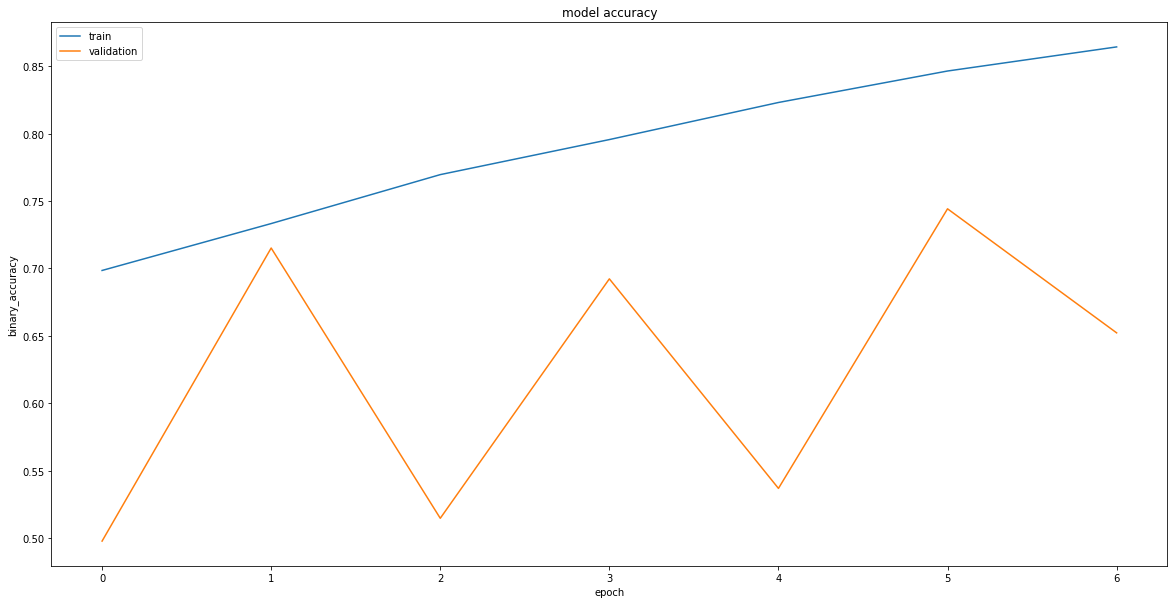

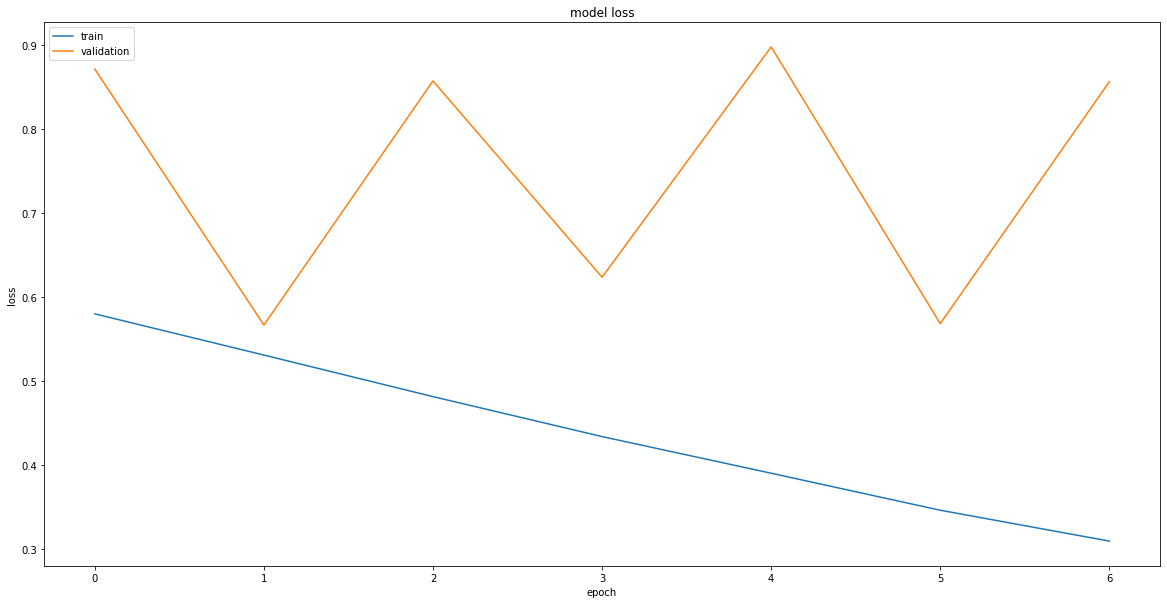

In [41]:
print(history_bilstm.history.keys())
# summarize history for accuracy
plt.plot(history_bilstm.history['binary_accuracy'])
plt.plot(history_bilstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
pred_lstm = lstm.predict(xt)

In [43]:
pred_lstm_bin = np.where(pred_lstm >= 0.50, 1, 0)

In [44]:
metrics(yt, pred_lstm_bin.flatten())

METRICS:
Accuracy score:
0.7691089439026423

Recall score:
0.7691051765268648

Precison score:
0.7713244082778558

F1-score:
0.76863497259268

MCC score:
0.5404250282348496

Confusion matrix:
[[4885 1114]
 [1656 4342]]

Classification report:
              precision    recall  f1-score   support

           0      0.747     0.814     0.779      5999
           1      0.796     0.724     0.758      5998

    accuracy                          0.769     11997
   macro avg      0.771     0.769     0.769     11997
weighted avg      0.771     0.769     0.769     11997




# LSTM with full descriptors

In [45]:
des_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/descriptors_all.csv'

des = ['MaxEStateIndex','MinEStateIndex','MaxAbsEStateIndex','MinAbsEStateIndex','qed','MolWt','HeavyAtomMolWt','ExactMolWt','NumValenceElectrons','NumRadicalElectrons','MaxPartialCharge','MinPartialCharge','MaxAbsPartialCharge','MinAbsPartialCharge','FpDensityMorgan1','FpDensityMorgan2','FpDensityMorgan3','BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO','BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW','BalabanJ','BertzCT','Chi0','Chi0n','Chi0v','Chi1','Chi1n','Chi1v','Chi2n','Chi2v','Chi3n','Chi3v','Chi4n','Chi4v','HallKierAlpha','Ipc','Kappa1','Kappa2','Kappa3','LabuteASA','PEOE_VSA1','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','PEOE_VSA14','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','SMR_VSA1','SMR_VSA10','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA10','SlogP_VSA11','SlogP_VSA12','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','TPSA','EState_VSA1','EState_VSA10','EState_VSA11','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','VSA_EState1','VSA_EState10','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9','FractionCSP3','HeavyAtomCount','NHOHCount','NOCount','NumAliphaticCarbocycles','NumAliphaticHeterocycles','NumAliphaticRings','NumAromaticCarbocycles','NumAromaticHeterocycles','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','RingCount','MolLogP','MolMR','fr_Al_COO','fr_Al_OH','fr_Al_OH_noTert','fr_ArN','fr_Ar_COO','fr_Ar_N','fr_Ar_NH','fr_Ar_OH','fr_COO','fr_COO2','fr_C_O','fr_C_O_noCOO','fr_C_S','fr_HOCCN','fr_Imine','fr_NH0','fr_NH1','fr_NH2','fr_N_O','fr_Ndealkylation1','fr_Ndealkylation2','fr_Nhpyrrole','fr_SH','fr_aldehyde','fr_alkyl_carbamate','fr_alkyl_halide','fr_allylic_oxid','fr_amide','fr_amidine','fr_aniline','fr_aryl_methyl','fr_azide','fr_azo','fr_barbitur','fr_benzene','fr_benzodiazepine','fr_bicyclic','fr_diazo','fr_dihydropyridine','fr_epoxide','fr_ester','fr_ether','fr_furan','fr_guanido','fr_halogen','fr_hdrzine','fr_hdrzone','fr_imidazole','fr_imide','fr_isocyan','fr_isothiocyan','fr_ketone','fr_ketone_Topliss','fr_lactam','fr_lactone','fr_methoxy','fr_morpholine','fr_nitrile','fr_nitro','fr_nitro_arom','fr_nitro_arom_nonortho','fr_nitroso','fr_oxazole','fr_oxime','fr_para_hydroxylation','fr_phenol','fr_phenol_noOrthoHbond','fr_phos_acid','fr_phos_ester','fr_piperdine','fr_piperzine','fr_priamide','fr_prisulfonamd','fr_pyridine','fr_quatN','fr_sulfide','fr_sulfonamd','fr_sulfone','fr_term_acetylene','fr_tetrazole','fr_thiazole','fr_thiocyan','fr_thiophene','fr_unbrch_alkane','fr_urea']

des_loader = CSVLoader(des_path, mols_field='smiles', labels_fields='activity', features_fields=des)
des_dataset = des_loader.create_dataset()
des_dataset.get_shape()

from scalers.sklearnScalers import StandardScaler
StandardScaler().fit_transform(des_dataset)

Mols_shape:  39989
Features_shape:  (39989, 208)
Labels_shape:  (39989,)


In [46]:
splitter = SingletaskStratifiedSplitter()
des_train_dataset, des_test_dataset = splitter.train_test_split(dataset=des_dataset, frac_train=0.7)

des_input_dim = des_train_dataset.X.shape[1]

(27986, 208)
X not defined!
Defined features extracted!
(11994, 208)


In [47]:
xx = np.reshape(des_train_dataset.X, (-1, 1, des_train_dataset.X.shape[1]))
yy = np.reshape(des_train_dataset.y, (-1, 1,))
xxt = np.reshape(des_test_dataset.X, (-1, 1, des_test_dataset.X.shape[1]))
yyt = np.reshape(des_test_dataset.y, (-1, 1,))

In [48]:
xx.shape

(27986, 1, 208)

In [49]:
yy.shape

(27986, 1)

In [50]:
lstm2 = Sequential()
lstm2.add(LSTM(128, input_shape=(xx.shape[1], xx.shape[2]), activation='relu', return_sequences=True))
lstm2.add(Dropout(0.2))
lstm2.add(LSTM(64, return_sequences=True))
lstm2.add(Dense(128, activation='relu'))
lstm2.add(Dropout(0.2))
lstm2.add(Dense(1, activation='sigmoid'))
# Compile model
lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [51]:
lstm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 128)            172544    
                                                                 
 dropout_8 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_9 (Dense)             (None, 1, 128)            8320      
                                                                 
 dropout_9 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_10 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 230,401
Trainable params: 230,401
Non-tr

In [52]:
print(f'Train data size: {des_train_dataset.X.shape}\nTrain labels size: {des_train_dataset.y.shape}')
history_lstm2 = lstm2.fit(xx, yy, validation_split=0.15, epochs=7, batch_size=32, verbose=1)

Train data size: (27986, 208)
Train labels size: (27986,)
Epoch 1/7
744/744 [==============================] - 10s 9ms/step - loss: 0.4719 - binary_accuracy: 0.7799 - val_loss: 0.6858 - val_binary_accuracy: 0.6639
Epoch 2/7
744/744 [==============================] - 6s 8ms/step - loss: 0.4183 - binary_accuracy: 0.8099 - val_loss: 0.5838 - val_binary_accuracy: 0.7134
Epoch 3/7
744/744 [==============================] - 5s 7ms/step - loss: 0.3909 - binary_accuracy: 0.8249 - val_loss: 0.4816 - val_binary_accuracy: 0.7716
Epoch 4/7
744/744 [==============================] - 5s 7ms/step - loss: 0.3667 - binary_accuracy: 0.8384 - val_loss: 0.6131 - val_binary_accuracy: 0.7094
Epoch 5/7
744/744 [==============================] - 6s 8ms/step - loss: 0.3432 - binary_accuracy: 0.8506 - val_loss: 0.5202 - val_binary_accuracy: 0.7468
Epoch 6/7
744/744 [==============================] - 5s 7ms/step - loss: 0.3240 - binary_accuracy: 0.8619 - val_loss: 0.5727 - val_binary_accuracy: 0.7370
Epoch 7/7
7

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


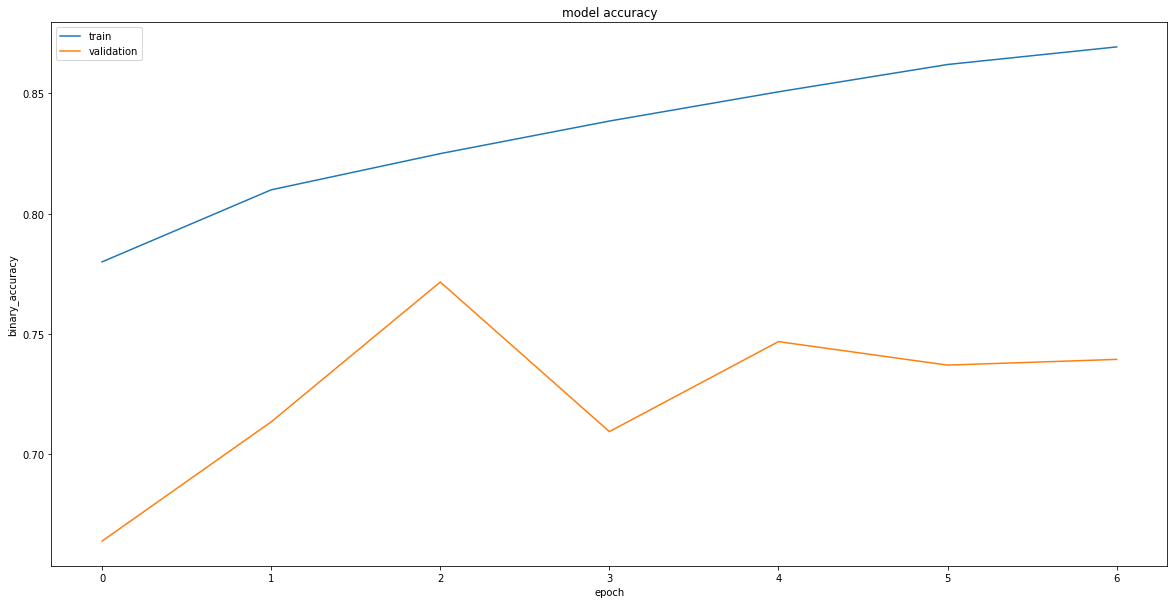

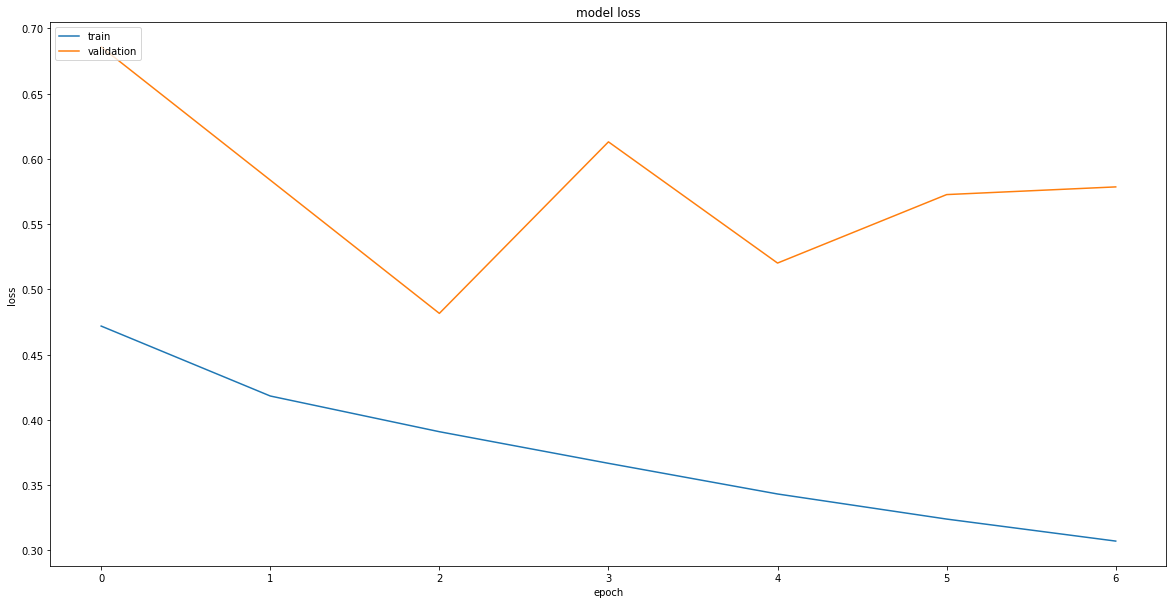

In [53]:
print(history_lstm2.history.keys())
# summarize history for accuracy
plt.plot(history_lstm2.history['binary_accuracy'])
plt.plot(history_lstm2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm2.history['loss'])
plt.plot(history_lstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [54]:
pred_lstm2 = lstm2.predict(xxt)

In [55]:
pred_lstm2_bin = np.where(pred_lstm2 >= 0.50, 1, 0)

In [56]:
metrics(yyt, pred_lstm2_bin.flatten())

METRICS:
Accuracy score:
0.8195764548941137

Recall score:
0.8195447947947948

Precison score:
0.8247744913026148

F1-score:
0.8188414037210532

MCC score:
0.6442980620112959

Confusion matrix:
[[5297  703]
 [1461 4533]]

Classification report:
              precision    recall  f1-score   support

           0      0.784     0.883     0.830      6000
           1      0.866     0.756     0.807      5994

    accuracy                          0.820     11994
   macro avg      0.825     0.820     0.819     11994
weighted avg      0.825     0.820     0.819     11994




# OLD

In [57]:
# from metrics.metricsFunctions import roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report
#
# def create_dnn_model(optimizer='adam', dropout=0.2, input_dim=input_dim):
#     # create model
#     model = Sequential()
#     model.add(Dense(1024, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(8, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     model.summary()
#     return model
#
# print(f'Input dim: {input_dim}')
# model = KerasModel(create_dnn_model, epochs=10, verbose=1, batch_size=150)
#
# print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
# model.fit(train_dataset)
#
# metrics = [Metric(roc_auc_score),
#            Metric(precision_score),
#            Metric(accuracy_score),
#            Metric(confusion_matrix),
#            Metric(classification_report)]
#
# print('training set score:', model.evaluate(train_dataset, metrics))
# print('test set score:', model.evaluate(test_dataset, metrics))